# Calibración de los modelos

In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import os
from os import listdir
from os.path import isfile, join

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model

#### Se cargan los modelos y los CSV de prueba y calibración + validación.

In [36]:
# Resized images directory
dir_2019_images = "/kaggle/input/resizedsiimisic/train_resized/"
dir_2020_images = "/kaggle/input/resizedsiimisic/test_resized/"
dir_2019_aug_images = "/kaggle/input/models/oversampling/train_resized/"

# CSV files
train_2019_df = pd.read_csv('/kaggle/input/resizedsiimisic/train.csv')
train_2020_df = pd.read_csv('/kaggle/input/resizedsiimisic/test.csv')

undersampling_calib = pd.read_csv('/kaggle/input/models/undersampling/calib.csv')
weighted_calib = pd.read_csv('/kaggle/input/models/weighted/calib.csv')
oversampling_calib = pd.read_csv('/kaggle/input/models/oversampling/calib.csv')

undersampling_val = pd.read_csv('/kaggle/input/models/undersampling/val.csv')
weighted_val = pd.read_csv('/kaggle/input/models/weighted/val.csv')
oversampling_val = pd.read_csv('/kaggle/input/models/oversampling/val.csv')

undersampling_test = pd.read_csv('/kaggle/input/models/undersampling/test.csv')
weighted_test = pd.read_csv('/kaggle/input/models/weighted/test.csv')
oversampling_test = pd.read_csv('/kaggle/input/models/oversampling/test.csv')

# Load models
undersampling = load_model('/kaggle/input/models/undersampling/undersampling_model.h5')
weighted = load_model('/kaggle/input/models/weighted/weighted_model.h5')
oversampling = load_model('/kaggle/input/models/oversampling/oversampling_model.h5')

#### Se unen el conjunto de validación y calibración a un único conjunto para la calibración de los modelos.

In [37]:
new_under_calib = pd.concat([undersampling_calib, undersampling_val], ignore_index=False)
new_under_calib = new_under_calib.reset_index()

new_weight_calib = pd.concat([weighted_calib, weighted_val], ignore_index=False)
new_weight_calib = new_weight_calib.reset_index()

new_over_calib = pd.concat([oversampling_calib, oversampling_val], ignore_index=False)
new_over_calib = new_over_calib.reset_index()

print("Conjunto de calibracion (undersampling):", len(undersampling_calib))
print("Conjunto de calibracion + validacion (undersampling):", len(new_under_calib))
print("------------------------")
print("Conjunto de calibracion (weighted):", len(weighted_calib))
print("Conjunto de calibracion + validacion (weighted):", len(new_weight_calib))
print("------------------------")
print("Conjunto de calibracion (oversampling):", len(oversampling_calib))
print("Conjunto de calibracion + validacion (oversampling):", len(new_over_calib))

Conjunto de calibracion (undersampling): 696
Conjunto de calibracion + validacion (undersampling): 2087
------------------------
Conjunto de calibracion (weighted): 1799
Conjunto de calibracion + validacion (weighted): 5396
------------------------
Conjunto de calibracion (oversampling): 1799
Conjunto de calibracion + validacion (oversampling): 5396


In [39]:
new_under_calib["target"] = new_under_calib['target'].astype(str)
new_weight_calib["target"] = new_weight_calib['target'].astype(str)
new_over_calib["target"] = new_over_calib['target'].astype(str)

undersampling_test["target"] = undersampling_test['target'].astype(str)
weighted_test["target"] = weighted_test['target'].astype(str)
oversampling_test["target"] = oversampling_test['target'].astype(str)

#### A continuación, se realiza las nuevas predicciones sobre el nuevo conjunto creado.

In [40]:
datagen = ImageDataGenerator(rescale=1./255.)

calib_generator_under = datagen.flow_from_dataframe(
    dataframe=new_under_calib,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

calib_generator_weight = datagen.flow_from_dataframe(
    dataframe=new_weight_calib,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

calib_generator_over = datagen.flow_from_dataframe(
    dataframe=new_over_calib,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator_under = datagen.flow_from_dataframe(
    dataframe=undersampling_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator_weight = datagen.flow_from_dataframe(
    dataframe=weighted_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator_over = datagen.flow_from_dataframe(
    dataframe=oversampling_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

Found 2087 validated image filenames belonging to 2 classes.
Found 5396 validated image filenames belonging to 2 classes.
Found 5396 validated image filenames belonging to 2 classes.
Found 1043 validated image filenames belonging to 2 classes.
Found 2697 validated image filenames belonging to 2 classes.
Found 2697 validated image filenames belonging to 2 classes.


In [41]:
true_labels_calib_under = calib_generator_under.classes
true_labels_calib_weight = calib_generator_weight.classes
true_labels_calib_over = calib_generator_over.classes

true_labels_test_under = test_generator_under.classes
true_labels_test_weight = test_generator_weight.classes
true_labels_test_over = test_generator_over.classes

predict_undersampling_calib = undersampling.predict(calib_generator_under, verbose=1)
predict_weighted_calib = weighted.predict(calib_generator_weight, verbose=1)
predict_oversampling_calib = oversampling.predict(calib_generator_over, verbose=1)

predict_undersampling_test = undersampling.predict(test_generator_under, verbose=1)
predict_weighted_test = weighted.predict(test_generator_weight, verbose=1)
predict_oversampling_test = oversampling.predict(test_generator_over, verbose=1)

85/85 [==============================] - 190s 2s/step


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, log_loss
!pip install ml_insights
import ml_insights as mli
!pip install betacal
from betacal import BetaCalibration

     |████████████████████████████████| 23.2 MB 1.5 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.1 which is incompatible.


#### A continuación, se realiza las predicciones con los modelos sobre el conjunto de prueba y calibración.

In [43]:
print('Calibracion Brier Score (undersampling) :', brier_score_loss(true_labels_calib_under, predict_undersampling_calib))
print('Calibracion Brier Score (weighted) :', brier_score_loss(true_labels_calib_weight, predict_weighted_calib))
print('Calibracion Brier Score (oversampling) :', brier_score_loss(true_labels_calib_over, predict_oversampling_calib))
print("-----------------------")
print('Test Brier Score (undersampling) :', brier_score_loss(true_labels_test_under, predict_undersampling_test))
print('Test Brier Score (weighted) :', brier_score_loss(true_labels_test_weight, predict_weighted_test))
print('Test Brier Score (oversampling) :', brier_score_loss(true_labels_test_over, predict_oversampling_test))

Calibracion Brier Score (undersampling) : 0.18994203866241183
Calibracion Brier Score (weighted) : 0.18754283780628703
Calibracion Brier Score (oversampling) : 0.159899871635167
-----------------------
Test Brier Score (undersampling) : 0.19643017355735037
Test Brier Score (weighted) : 0.19367899912613784
Test Brier Score (oversampling) : 0.16538214970662457


In [51]:
def plot_reliability_diagram(true_labels, predict_labels):
    plt.figure(figsize=(15,5))
    rd = mli.plot_reliability_diagram(true_labels, predict_labels, show_histogram=True)
    return rd

Reliability Diagram Undersampling on Calibration Data


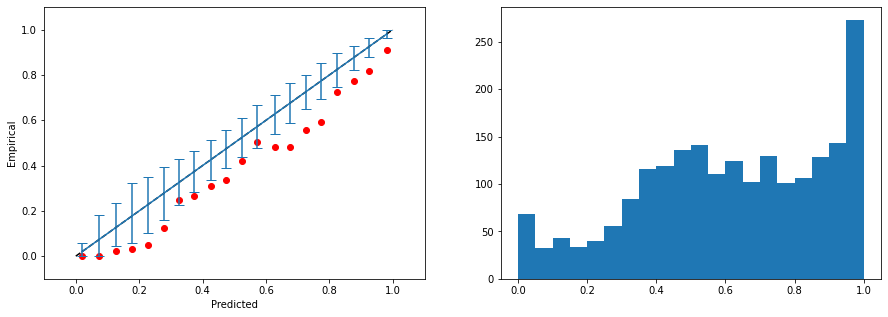

In [52]:
rd = plot_reliability_diagram(np.array(true_labels_calib_under), predict_undersampling_calib.ravel())
print('Reliability Diagram Undersampling on Calibration Data')

Reliability Diagram Weighted on Calibration Data


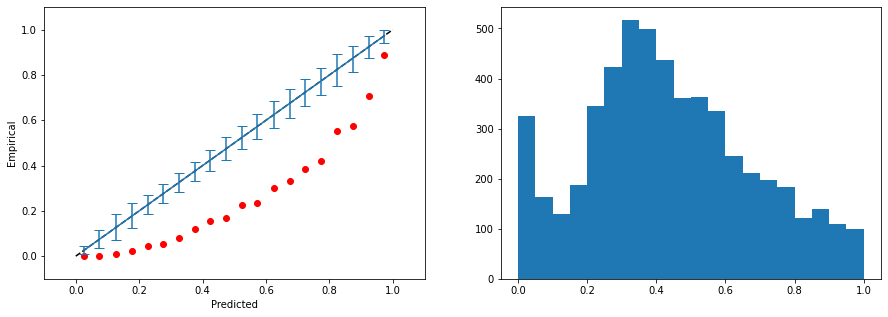

In [53]:
rd = plot_reliability_diagram(np.array(true_labels_calib_weight), predict_weighted_calib.ravel())
print('Reliability Diagram Weighted on Calibration Data')

Reliability Diagram Oversampling on Calibration Data


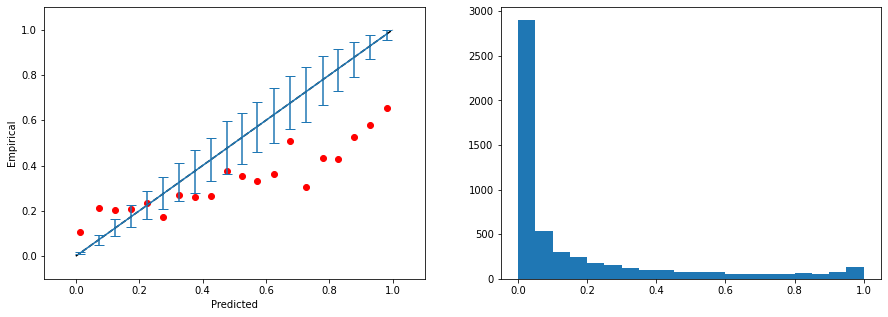

In [54]:
rd = plot_reliability_diagram(np.array(true_labels_calib_over), predict_oversampling_calib.ravel())
print('Reliability Diagram Oversampling on Calibration Data')

Reliability Diagram Undersampling on Test Data


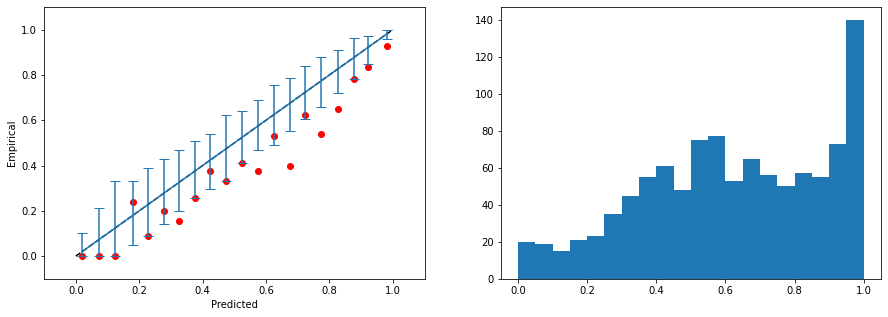

In [55]:
rd = plot_reliability_diagram(np.array(true_labels_test_under),predict_undersampling_test.ravel())
print('Reliability Diagram Undersampling on Test Data')

Reliability Diagram Weighted on Test Data


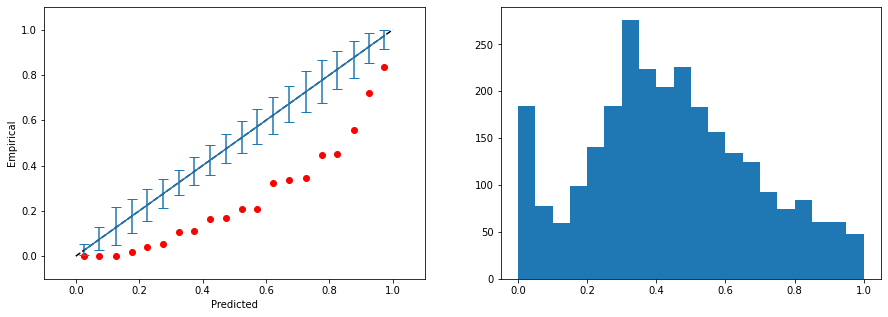

In [56]:
rd = plot_reliability_diagram(np.array(true_labels_test_weight),predict_weighted_test.ravel())
print('Reliability Diagram Weighted on Test Data')

Reliability Diagram Oversampling on Test Data


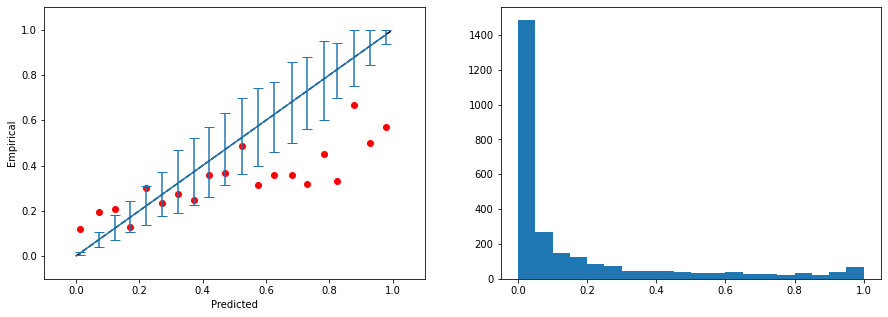

In [57]:
rd = plot_reliability_diagram(np.array(true_labels_test_over),predict_oversampling_test.ravel())
print('Reliability Diagram Oversampling on Test Data')

#### Se aplican los métodos de calibración sobre los tres modelos.

basado en: https://www.youtube.com/watch?v=A1NGGV3Z4m4

#### Método 1: Platt Scaling

In [58]:
# Fit Platt scaling (logistic calibration)
lr_under = LogisticRegression(C=99999999999, solver='lbfgs')
lr_under.fit(predict_undersampling_calib.reshape(-1,1), np.array(true_labels_calib_under))

lr_weight = LogisticRegression(C=99999999999, solver='lbfgs')
lr_weight.fit(predict_weighted_calib.reshape(-1,1), np.array(true_labels_calib_weight))

lr_over = LogisticRegression(C=99999999999, solver='lbfgs')
lr_over.fit(predict_oversampling_calib.reshape(-1,1), np.array(true_labels_calib_over))

LogisticRegression(C=99999999999)

In [59]:
calibset_platt_probs_under = lr_under.predict_proba(predict_undersampling_calib.reshape(-1,1))[:,1]
testset_platt_probs_under = lr_under.predict_proba(predict_undersampling_test.reshape(-1,1))[:,1]

calibset_platt_probs_weight = lr_weight.predict_proba(predict_weighted_calib.reshape(-1,1))[:,1]
testset_platt_probs_weight = lr_weight.predict_proba(predict_weighted_test.reshape(-1,1))[:,1]

calibset_platt_probs_over = lr_over.predict_proba(predict_oversampling_calib.reshape(-1,1))[:,1]
testset_platt_probs_over = lr_over.predict_proba(predict_oversampling_test.reshape(-1,1))[:,1]

#### Método 2: Isotonic Regression

In [60]:
iso_under = IsotonicRegression(out_of_bounds = 'clip')
iso_under.fit(predict_undersampling_calib.ravel(), np.array(true_labels_calib_under))

iso_weight = IsotonicRegression(out_of_bounds = 'clip')
iso_weight.fit(predict_weighted_calib.ravel(), np.array(true_labels_calib_weight))

iso_over = IsotonicRegression(out_of_bounds = 'clip')
iso_over.fit(predict_oversampling_calib.ravel(), np.array(true_labels_calib_over))

IsotonicRegression(out_of_bounds='clip')

In [61]:
calibset_iso_probs_under = iso_under.predict(predict_undersampling_calib.ravel())
testset_iso_probs_under = iso_under.predict(predict_undersampling_test.ravel())

calibset_iso_probs_weight = iso_weight.predict(predict_weighted_calib.ravel())
testset_iso_probs_weight = iso_weight.predict(predict_weighted_test.ravel())

calibset_iso_probs_over = iso_over.predict(predict_oversampling_calib.ravel())
testset_iso_probs_over = iso_over.predict(predict_oversampling_test.ravel())

#### Método 3: Beta Calibration

In [62]:
# Fit three-parameter beta calibration
bc_under = BetaCalibration()
bc_under.fit(predict_undersampling_calib.ravel(), np.array(true_labels_calib_under))

bc_weight = BetaCalibration()
bc_weight.fit(predict_weighted_calib.ravel(), np.array(true_labels_calib_weight))

bc_over = BetaCalibration()
bc_over.fit(predict_oversampling_calib.ravel(), np.array(true_labels_calib_over))

BetaCalibration()

In [63]:
calibset_bc_probs_under = bc_under.predict(predict_undersampling_calib.ravel())
testset_bc_probs_under = bc_under.predict(predict_undersampling_test.ravel())

calibset_bc_probs_weight = bc_under.predict(predict_weighted_calib.ravel())
testset_bc_probs_weight = bc_under.predict(predict_weighted_test.ravel())

calibset_bc_probs_over = bc_over.predict(predict_oversampling_calib.ravel())
testset_bc_probs_over = bc_over.predict(predict_oversampling_test.ravel())

#### Método 4: SplineCalib

In [64]:
# Define SplineCalib object
splinecalib_under = mli.SplineCalib()
splinecalib_under.fit(predict_undersampling_calib.ravel(), np.array(true_labels_calib_under))

splinecalib_weight = mli.SplineCalib()
splinecalib_weight.fit(predict_weighted_calib.ravel(), np.array(true_labels_calib_weight))

splinecalib_over = mli.SplineCalib()
splinecalib_over.fit(predict_oversampling_calib.ravel(), np.array(true_labels_calib_over))

In [65]:
calibset_splinecalib_probs_under = splinecalib_under.predict(predict_undersampling_calib.ravel())
testset_splinecalib_probs_under = splinecalib_under.predict(predict_undersampling_test.ravel())

calibset_splinecalib_probs_weight = splinecalib_weight.predict(predict_weighted_calib.ravel())
testset_splinecalib_probs_weight = splinecalib_weight.predict(predict_weighted_test.ravel())

calibset_splinecalib_probs_over = splinecalib_over.predict(predict_oversampling_calib.ravel())
testset_splinecalib_probs_over = splinecalib_over.predict(predict_oversampling_test.ravel())

## <font color=red>1. </font>Calibración del modelo de submuestreo

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n before Platt Calibration')

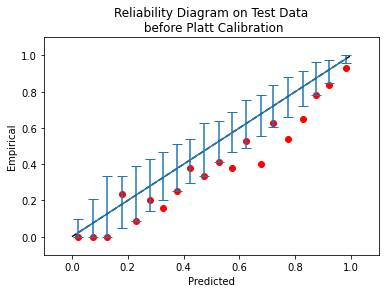

In [66]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), predict_undersampling_test.ravel())
plt.title('Reliability Diagram on Test Data\n before Platt Calibration')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Platt Calibration')

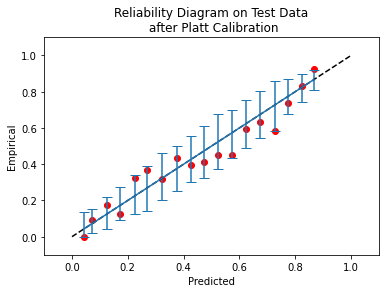

In [67]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), testset_platt_probs_under.ravel())
plt.title('Reliability Diagram on Test Data\n after Platt Calibration')

Text(0.5, 1.0, 'Isotonic Calibration Curve on Test Data')

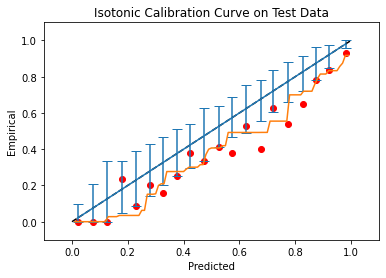

In [68]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), predict_undersampling_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso_under.predict(tvec), label='Isotonic')
plt.title('Isotonic Calibration Curve on Test Data')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Isotonic Calibration')

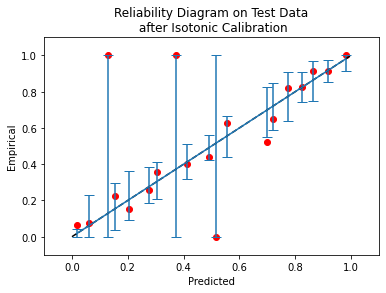

In [69]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), testset_iso_probs_under)
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration')

Text(0.5, 1.0, 'Beta Calibration Curve on Test Set')

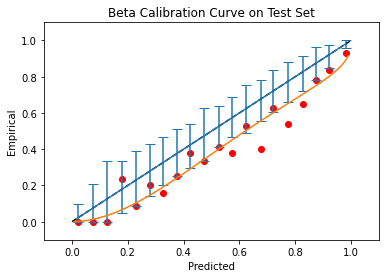

In [70]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), predict_undersampling_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc_under.predict(tvec))
plt.title('Beta Calibration Curve on Test Set')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Beta Calibration')

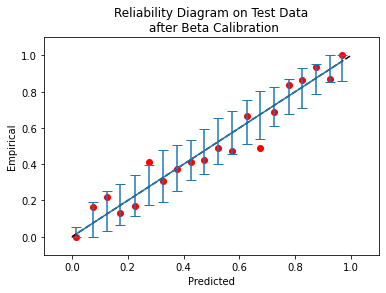

In [71]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), testset_bc_probs_under)
plt.title('Reliability Diagram on Test Data\n after Beta Calibration')

Text(0.5, 1.0, 'SplineCalib Calibration Curve on Test Set')

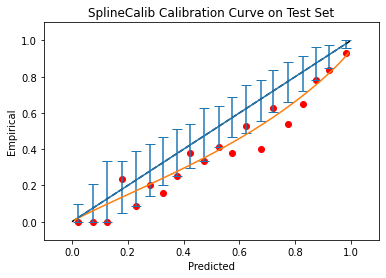

In [72]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), predict_undersampling_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib_under.predict(tvec))
plt.title('SplineCalib Calibration Curve on Test Set')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after SplineCalib Calibration')

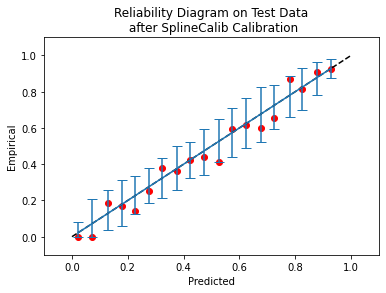

In [73]:
mli.plot_reliability_diagram(np.array(true_labels_test_under), testset_splinecalib_probs_under)
plt.title('Reliability Diagram on Test Data\n after SplineCalib Calibration')

## <font color=red>2. </font>Calibración del modelo de función de pérdida ponderada

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n before Platt Calibration')

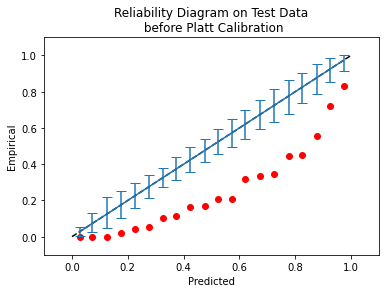

In [74]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), predict_weighted_test.ravel())
plt.title('Reliability Diagram on Test Data\n before Platt Calibration')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Platt Calibration')

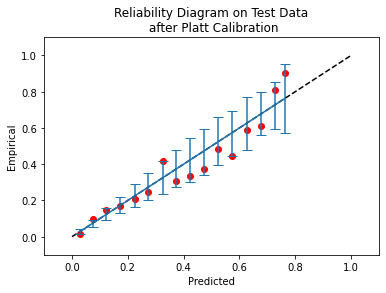

In [75]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), testset_platt_probs_weight.ravel())
plt.title('Reliability Diagram on Test Data\n after Platt Calibration')

Text(0.5, 1.0, 'Isotonic Calibration Curve on Test Data')

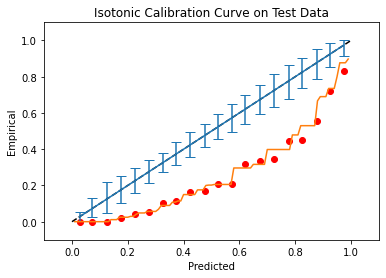

In [76]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), predict_weighted_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso_weight.predict(tvec), label='Isotonic')
plt.title('Isotonic Calibration Curve on Test Data')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Isotonic Calibration')

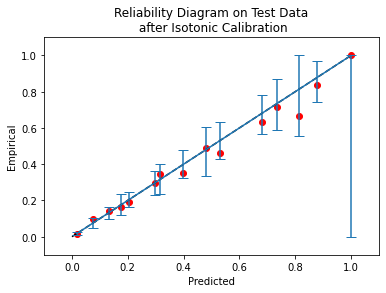

In [77]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), testset_iso_probs_weight)
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration')

Text(0.5, 1.0, 'Beta Calibration Curve on Test Set')

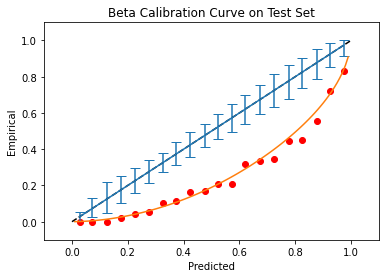

In [78]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), predict_weighted_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc_weight.predict(tvec))
plt.title('Beta Calibration Curve on Test Set')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Beta Calibration')

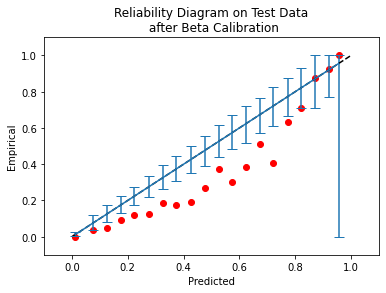

In [79]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), testset_bc_probs_weight)
plt.title('Reliability Diagram on Test Data\n after Beta Calibration')

Text(0.5, 1.0, 'SplineCalib Calibration Curve on Test Set')

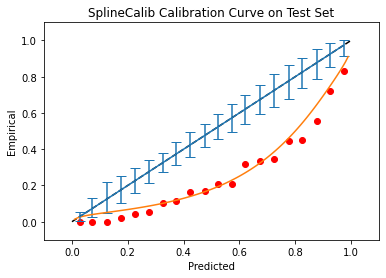

In [80]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), predict_weighted_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib_weight.predict(tvec))
plt.title('SplineCalib Calibration Curve on Test Set')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after SplineCalib Calibration')

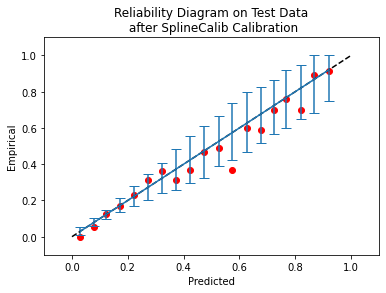

In [81]:
mli.plot_reliability_diagram(np.array(true_labels_test_weight), testset_splinecalib_probs_weight)
plt.title('Reliability Diagram on Test Data\n after SplineCalib Calibration')

## <font color=red>3. </font>Calibración del modelo de sobremuestreo

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n before Platt Calibration')

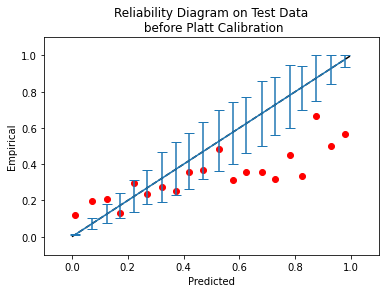

In [82]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), predict_oversampling_test.ravel())
plt.title('Reliability Diagram on Test Data\n before Platt Calibration')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Platt Calibration')

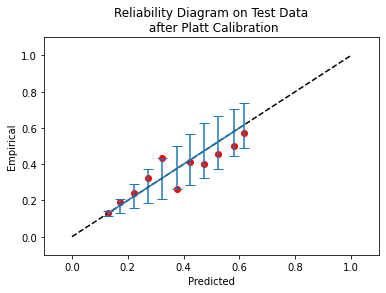

In [83]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), testset_platt_probs_over.ravel())
plt.title('Reliability Diagram on Test Data\n after Platt Calibration')

Text(0.5, 1.0, 'Isotonic Calibration Curve on Test Data')

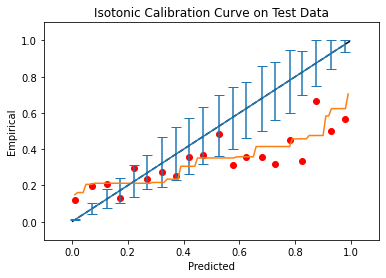

In [84]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), predict_oversampling_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, iso_over.predict(tvec), label='Isotonic')
plt.title('Isotonic Calibration Curve on Test Data')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Isotonic Calibration')

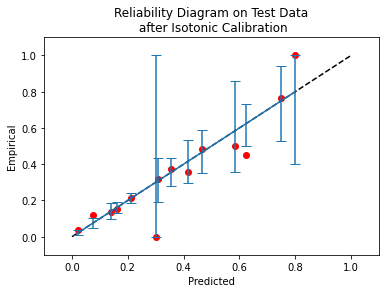

In [85]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), testset_iso_probs_over)
plt.title('Reliability Diagram on Test Data\n after Isotonic Calibration')

Text(0.5, 1.0, 'Beta Calibration Curve on Test Set')

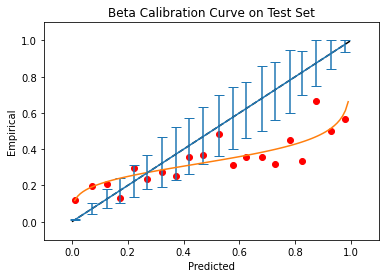

In [86]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), predict_oversampling_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, bc_over.predict(tvec))
plt.title('Beta Calibration Curve on Test Set')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after Beta Calibration')

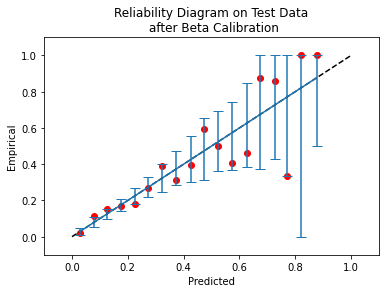

In [87]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), testset_bc_probs_over)
plt.title('Reliability Diagram on Test Data\n after Beta Calibration')

Text(0.5, 1.0, 'SplineCalib Calibration Curve on Test Set')

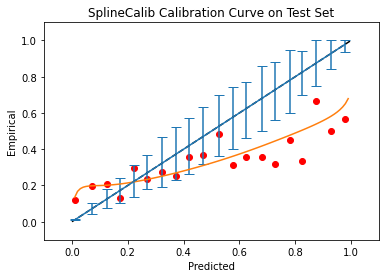

In [88]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), predict_oversampling_test.ravel())
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, splinecalib_over.predict(tvec))
plt.title('SplineCalib Calibration Curve on Test Set')

Text(0.5, 1.0, 'Reliability Diagram on Test Data\n after SplineCalib Calibration')

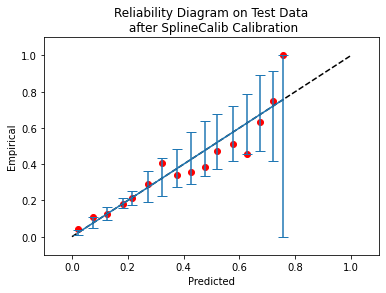

In [89]:
mli.plot_reliability_diagram(np.array(true_labels_test_over), testset_splinecalib_probs_over)
plt.title('Reliability Diagram on Test Data\n after SplineCalib Calibration')

#### Métricas

In [90]:
print("Undersampling model")
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_under, predict_undersampling_test.ravel())))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_under, testset_platt_probs_under)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_under, testset_iso_probs_under)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_under, testset_bc_probs_under)))
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_under, testset_splinecalib_probs_under)))
print("-----------------------")
print("Weighted model")
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_weight, predict_weighted_test.ravel())))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_weight, testset_platt_probs_weight)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_weight, testset_iso_probs_weight)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_weight, testset_bc_probs_weight)))
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_weight, testset_splinecalib_probs_weight)))
print("-----------------------")
print("Oversampling model")
print('Uncalibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_over, predict_oversampling_test.ravel())))
print('Platt calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_over, testset_platt_probs_over)))
print('Isotonic calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_over, testset_iso_probs_over)))
print('Beta calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_over, testset_bc_probs_over)))
print('Spline calibrated Brier Score = {}'.format(brier_score_loss(true_labels_test_over, testset_splinecalib_probs_over)))

Undersampling model
Uncalibrated Brier Score = 0.19643017355735037
Platt calibrated Brier Score = 0.18295210617861604
Isotonic calibrated Brier Score = 0.1820289363398633
Beta calibrated Brier Score = 0.18144681183602762
Spline calibrated Brier Score = 0.18066745388994718
-----------------------
Weighted model
Uncalibrated Brier Score = 0.19367899912613784
Platt calibrated Brier Score = 0.12471899377083945
Isotonic calibrated Brier Score = 0.12396863749381354
Beta calibrated Brier Score = 0.14619060148718888
Spline calibrated Brier Score = 0.12430108276424792
-----------------------
Oversampling model
Uncalibrated Brier Score = 0.16538214970662457
Platt calibrated Brier Score = 0.14375656794558542
Isotonic calibrated Brier Score = 0.14185370171660214
Beta calibrated Brier Score = 0.14161221962091497
Spline calibrated Brier Score = 0.1420620114203973


In [91]:
print("Undersampling model")
print('Uncalibrated log_loss = {}'.format(log_loss(true_labels_test_under, predict_undersampling_test.ravel())))
print('Platt calibrated log_loss = {}'.format(log_loss(true_labels_test_under, testset_platt_probs_under)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(true_labels_test_under, testset_iso_probs_under)))
print('Beta calibrated log_loss = {}'.format(log_loss(true_labels_test_under, testset_bc_probs_under)))
print('Spline calibrated log_loss = {}'.format(log_loss(true_labels_test_under, testset_splinecalib_probs_under)))
print("-----------------------")
print("Weighted model")
print('Uncalibrated log_loss = {}'.format(log_loss(true_labels_test_weight, predict_weighted_test.ravel())))
print('Platt calibrated log_loss = {}'.format(log_loss(true_labels_test_weight, testset_platt_probs_weight)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(true_labels_test_weight, testset_iso_probs_weight)))
print('Beta calibrated log_loss = {}'.format(log_loss(true_labels_test_weight, testset_bc_probs_weight)))
print('Spline calibrated log_loss = {}'.format(log_loss(true_labels_test_weight, testset_splinecalib_probs_weight)))
print("-----------------------")
print("Oversampling model")
print('Uncalibrated log_loss = {}'.format(log_loss(true_labels_test_over, predict_oversampling_test.ravel())))
print('Platt calibrated log_loss = {}'.format(log_loss(true_labels_test_over, testset_platt_probs_over)))
print('Isotonic calibrated log_loss = {}'.format(log_loss(true_labels_test_over, testset_iso_probs_over)))
print('Beta calibrated log_loss = {}'.format(log_loss(true_labels_test_over, testset_bc_probs_over)))
print('Spline calibrated log_loss = {}'.format(log_loss(true_labels_test_over, testset_splinecalib_probs_over)))

Undersampling model
Uncalibrated log_loss = 0.5819147978812871
Platt calibrated log_loss = 0.5408036760499249
Isotonic calibrated log_loss = 0.5369157858552547
Beta calibrated log_loss = 0.5353521278630234
Spline calibrated log_loss = 0.5345193173229305
-----------------------
Weighted model
Uncalibrated log_loss = 0.5681128732800176
Platt calibrated log_loss = 0.39373838172335535
Isotonic calibrated log_loss = nan
Beta calibrated log_loss = 0.44516356954526815
Spline calibrated log_loss = 0.39453729372381835
-----------------------
Oversampling model
Uncalibrated log_loss = 0.6262694946202421
Platt calibrated log_loss = 0.4564060550511958
Isotonic calibrated log_loss = 0.446313210894258
Beta calibrated log_loss = 0.4458195461552188
Spline calibrated log_loss = 0.4468750125675048


#### Modelo submuestreo

In [120]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_test_under, 
                      np.where(np.array(predict_undersampling_test.ravel()) > 0.5, 1, 0))
cm1 = confusion_matrix(true_labels_test_under, 
                      np.where(np.array(testset_platt_probs_under.ravel()) > 0.5, 1, 0))
cm2 = confusion_matrix(true_labels_test_under, 
                      np.where(np.array(testset_iso_probs_under.ravel()) > 0.5, 1, 0))
cm3 = confusion_matrix(true_labels_test_under, 
                      np.where(np.array(testset_bc_probs_under.ravel()) > 0.5, 1, 0))
cm4 = confusion_matrix(true_labels_test_under, 
                      np.where(np.array(testset_splinecalib_probs_under.ravel()) > 0.5, 1, 0))

print("No calibration\n", cm)
print("Platt\n", cm1)
print("Iso\n", cm2)
print("Beta\n", cm3)
print("Spline\n", cm4)

No calibration
 [[268 254]
 [ 74 447]]
Platt
 [[373 149]
 [146 375]]
Iso
 [[427  95]
 [195 326]]
Beta
 [[371 151]
 [145 376]]
Spline
 [[383 139]
 [158 363]]


#### Modelo con función de pérdida ponderada

In [122]:
cm = confusion_matrix(true_labels_test_weight, 
                      np.where(np.array(predict_weighted_test.ravel()) > 0.5, 1, 0))
cm1 = confusion_matrix(true_labels_test_weight, 
                      np.where(np.array(testset_platt_probs_weight.ravel()) > 0.5, 1, 0))
cm2 = confusion_matrix(true_labels_test_weight, 
                      np.where(np.array(testset_iso_probs_weight.ravel()) > 0.5, 1, 0))
cm3 = confusion_matrix(true_labels_test_weight, 
                      np.where(np.array(testset_bc_probs_weight.ravel()) > 0.5, 1, 0))
cm4 = confusion_matrix(true_labels_test_weight, 
                      np.where(np.array(testset_splinecalib_probs_weight.ravel()) > 0.5, 1, 0))

print("No calibration\n", cm)
print("Platt\n", cm1)
print("Iso\n", cm2)
print("Beta\n", cm3)
print("Spline\n", cm4)

No calibration
 [[1533  643]
 [ 144  377]]
Platt
 [[2059  117]
 [ 346  175]]
Iso
 [[2089   87]
 [ 374  147]]
Beta
 [[1854  322]
 [ 235  286]]
Spline
 [[2078   98]
 [ 365  156]]


#### Modelo sobremuestreo

In [124]:
cm = confusion_matrix(true_labels_test_over, 
                      np.where(np.array(predict_oversampling_test.ravel()) > 0.5, 1, 0))
cm1 = confusion_matrix(true_labels_test_over, 
                      np.where(np.array(testset_platt_probs_over.ravel()) > 0.5, 1, 0))
cm2 = confusion_matrix(true_labels_test_over, 
                      np.where(np.array(testset_iso_probs_over.ravel()) > 0.5, 1, 0))
cm3 = confusion_matrix(true_labels_test_over, 
                      np.where(np.array(testset_bc_probs_over.ravel()) > 0.5, 1, 0))
cm4 = confusion_matrix(true_labels_test_over, 
                      np.where(np.array(testset_splinecalib_probs_over.ravel()) > 0.5, 1, 0))

print("No calibration\n", cm)
print("Platt\n", cm1)
print("Iso\n", cm2)
print("Beta\n", cm3)
print("Spline\n", cm4)

No calibration
 [[1987  189]
 [ 370  151]]
Platt
 [[2097   79]
 [ 437   84]]
Iso
 [[2130   46]
 [ 467   54]]
Beta
 [[2131   45]
 [ 468   53]]
Spline
 [[2106   70]
 [ 442   79]]


In [125]:
under_test_predictions = pd.read_csv('/kaggle/input/models/undersampling/under_test_predictions.csv')
weight_test_predictions = pd.read_csv('/kaggle/input/models/weighted/weight_test_predictions.csv')
over_test_predictions = pd.read_csv('/kaggle/input/models/oversampling/over_test_predictions.csv')

In [126]:
under_test_predictions['Undersampling Classifier prediction'] = predict_undersampling_test
weight_test_predictions['Weighted Classifier prediction'] = predict_weighted_test
over_test_predictions['Oversampling Classifier prediction'] = predict_oversampling_test

# Platt
under_test_predictions['Undersampling Platt prediction'] = testset_platt_probs_under
weight_test_predictions['Weighted Platt prediction'] = testset_platt_probs_weight
over_test_predictions['Oversampling Platt prediction'] = testset_platt_probs_over

# Iso
under_test_predictions['Undersampling Iso prediction'] = testset_iso_probs_under
weight_test_predictions['Weighted Iso prediction'] = testset_iso_probs_weight
over_test_predictions['Oversampling Iso prediction'] = testset_iso_probs_over

# Beta
under_test_predictions['Undersampling Beta prediction'] = testset_bc_probs_under
weight_test_predictions['Weighted Beta prediction'] = testset_bc_probs_weight
over_test_predictions['Oversampling Beta prediction'] = testset_bc_probs_over

# Spline
under_test_predictions['Undersampling Spline prediction'] = testset_splinecalib_probs_under
weight_test_predictions['Weighted Spline prediction'] = testset_splinecalib_probs_weight
over_test_predictions['Oversampling Spline prediction'] = testset_splinecalib_probs_over

In [127]:
under_test_predictions.head()

,Ground Truth,Undersampling Classifier prediction,Undersampling Platt prediction,Undersampling Iso prediction,Undersampling Beta prediction,Undersampling Spline prediction
0,0,0.392752,0.231180,0.276730,0.258528,0.289603
1,1,0.974532,0.862327,0.917722,0.877655,0.901613
2,0,0.248384,0.123994,0.062500,0.119202,0.184097
3,1,0.979658,0.865473,0.917722,0.888352,0.910631
4,0,0.658155,0.545752,0.492424,0.537966,0.513320


In [128]:
weight_test_predictions.head()

,Ground Truth,Weighted Classifier prediction,Weighted Platt prediction,Weighted Iso prediction,Weighted Beta prediction,Weighted Spline prediction
0,0,0.472179,0.155389,0.175610,0.342875,0.163390
1,0,0.016774,0.014383,0.000000,0.000780,0.019026
2,0,0.157007,0.030863,0.011236,0.051849,0.057702
3,0,0.469655,0.153555,0.175610,0.340173,0.162034
4,1,0.432915,0.128819,0.149660,0.300925,0.143604


In [129]:
over_test_predictions.head()

,Ground Truth,Oversampling Classifier prediction,Oversampling Platt prediction,Oversampling Iso prediction,Oversampling Beta prediction,Oversampling Spline prediction
0,0,0.030087,0.130282,0.160804,0.154766,0.182453
1,0,0.000008,0.122029,0.000000,0.017314,0.007995
2,0,0.009763,0.124655,0.136508,0.116695,0.133888
3,0,0.011657,0.125170,0.149123,0.122056,0.142535
4,1,0.007069,0.123925,0.136508,0.107477,0.118217


In [113]:
under_test_predictions.to_csv('/kaggle/working/under_test_predictions.csv', index=False)
weight_test_predictions.to_csv('/kaggle/working/weight_test_predictions.csv', index=False)
over_test_predictions.to_csv('/kaggle/working/over_test_predictions.csv', index=False)